# Imports

## Globals

In [20]:
from torch.utils.data import DataLoader
import gc
import torch
from tqdm.notebook import tqdm
import math

device = torch.device('cuda:0')

## Inference Files

In [2]:
from global_utils.weighted_boxes_fusion.ensemble_boxes import nms, soft_nms, non_maximum_weighted, weighted_boxes_fusion

## Models

### Faster-RCNN

In [3]:
from fasterrcnn.config import config as frcnn_config
from fasterrcnn.utils.inferencefns import WheatInferenceDataset as frcnn_WheatInferenceDataset
from fasterrcnn.utils.inferencefns import collate_fn as rcnn_collate_fn
from fasterrcnn.model import get_model as frcnn_get_model

frcnn_model_path = 'saved_weights/fasterrcnn/GWD_FASTERRCNN_0624V01_EPOCH_7_CHECKPOINT_0_SCORE_0.0000_LOSS_192.0324.pth'

frcnn_conf = frcnn_config()
frcnn_conf.DEVICE = device

frcnn_model = frcnn_get_model(device, saved_weights = frcnn_model_path)
frcnn_model.eval()

WD_Inference = frcnn_WheatInferenceDataset(frcnn_conf, normalize=False)

In [ ]:
frcnn_model2_path = 'saved_weights/fasterrcnn/old/model_aug/GWD_EPOCH_109_SCORE_0.0000_LOSS_182.9017.pt'
frcnn_model2 = torch.load(frcnn_model2_path, map_location=frcnn_conf.DEVICE)
_ = frcnn_model2.eval()



# Infer

In [26]:
models = [frcnn_model , frcnn_model2]
all_outputs = {idx:[] for idx in WD_Inference.IMGS}

for i in range(len(WD_Inference)):
    
    idx, image = WD_Inference[i]
    image = torch.tensor(image).to(device)
    
    for model in models:
        results = model([image])
        results = [{k: v.to(torch.device('cpu')).detach().numpy() for k, v in result.items()} for result in results]
        all_outputs[idx].append(results[0])
    


# Fuse

In [34]:
fused_outputs = {idx:[] for idx in WD_Inference.IMGS}
for image in WD_Inference.IMGS:
    boxes=[]
    scores = []
    labels=[]
    
    for i in range(len(models)):
        boxes.append(all_outputs[image][i]['boxes']/1024)
        scores.append(all_outputs[image][i]['scores'])
        labels.append(all_outputs[image][i]['labels'])   
    
    b, s, l = weighted_boxes_fusion(boxes, scores, labels, weights=[1.5, 1], iou_thr=0.50, skip_box_thr=0.1)
    fused_outputs[image].append({'boxes': b*1024, 'scores':s, 'labels':l})

# Output Test

In [38]:
import cv2
import matplotlib.pyplot as plt
def plot_boxes(img, boxes, scores):
    img = np.array(np.moveaxis(img, 0, -1)*255, dtype=np.int16)
    print(len(boxes))
    #img-=np.min(img)
    #img = img/np.max(img)
    thickness = 2
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color = (255, 0, 0)
    for (b, s) in zip(boxes, scores):
        img = cv2.rectangle(img, (b[0],b[1]), (b[2],b[3]), (255,0,0), 2)
        img = cv2.putText(img, '{:.2}'.format(s), (int(b[0])+np.random.randint(3),int(b[1])), font, fontScale, color, thickness, cv2.LINE_AA)
    return img

In [39]:
images = [image[1] for image in WD_Inference]

21
23
21


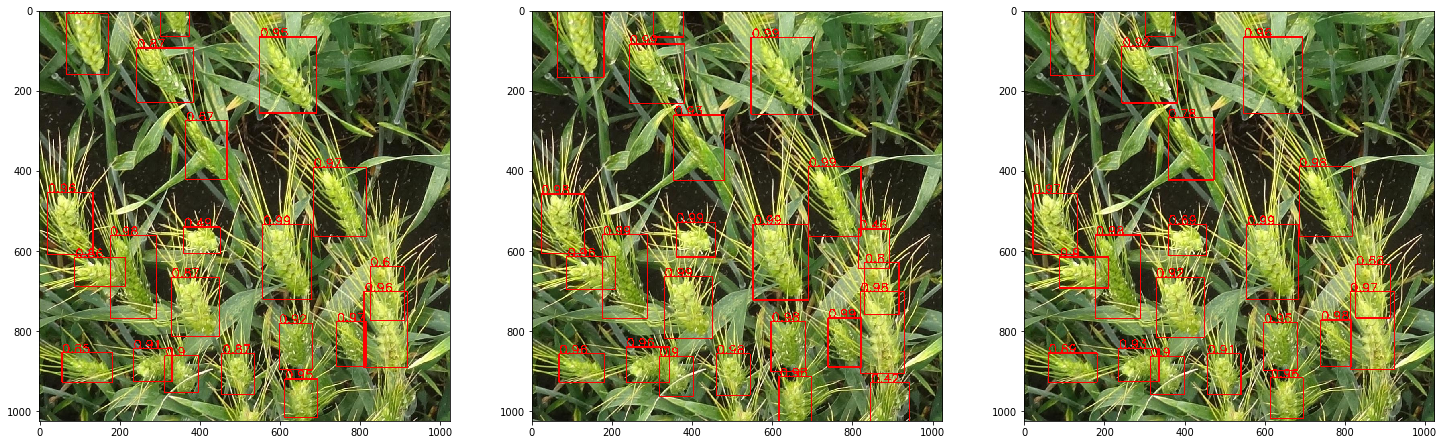

23
19
19


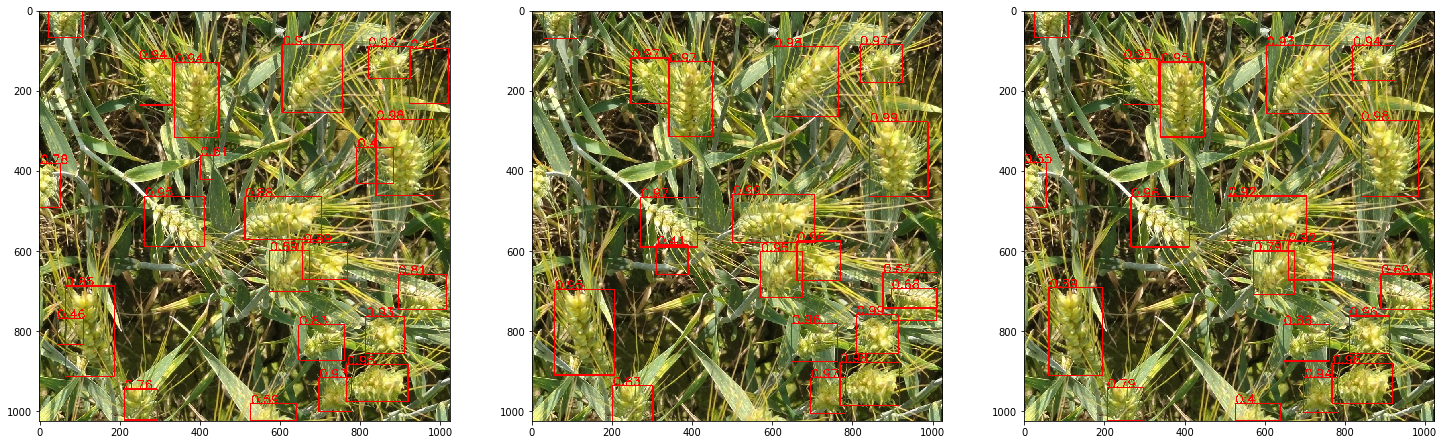

28
31
28


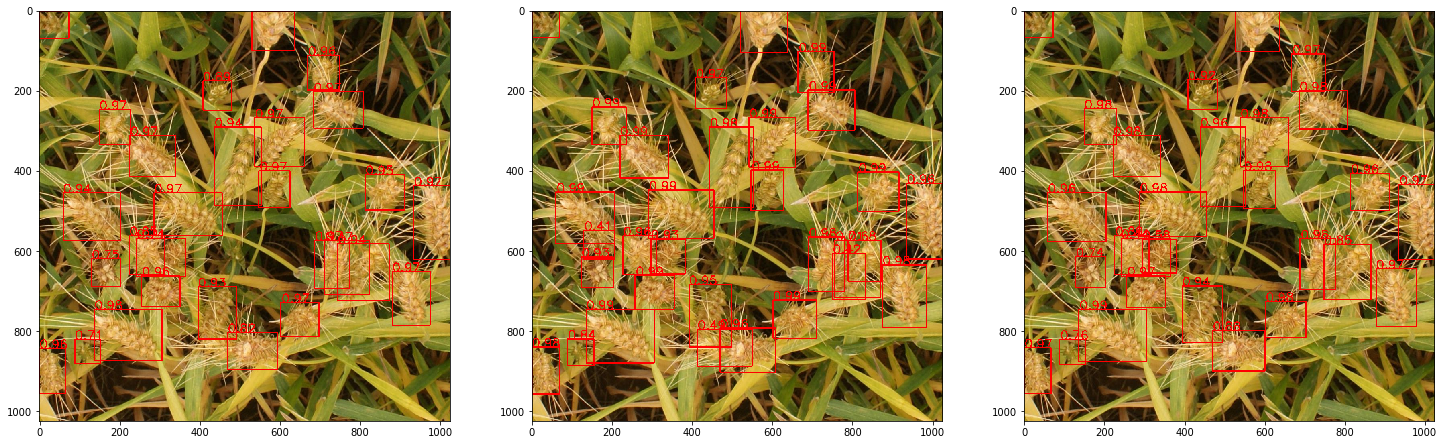

26
28
28


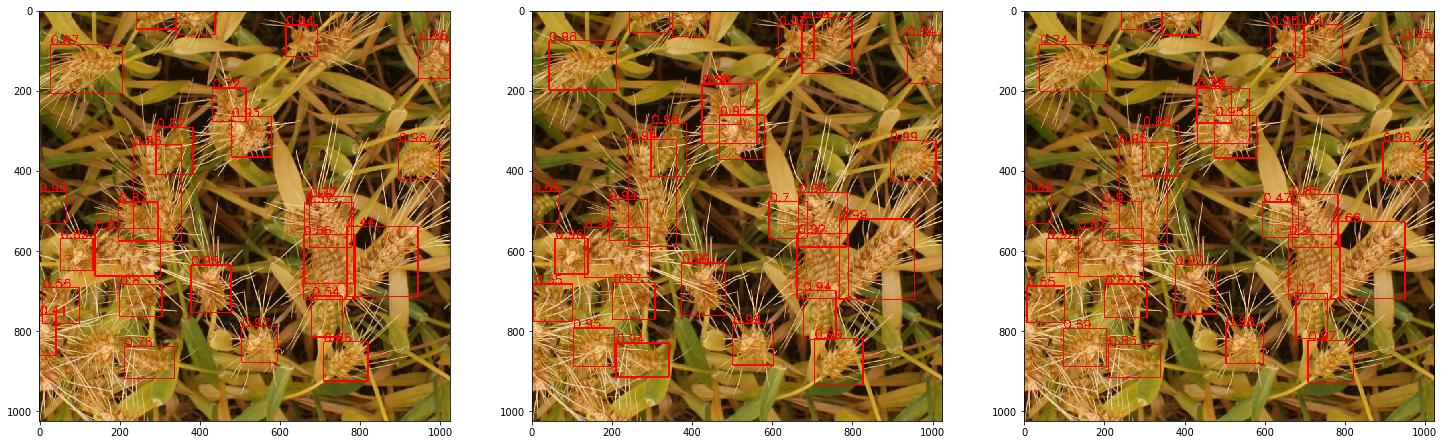

26
24
24


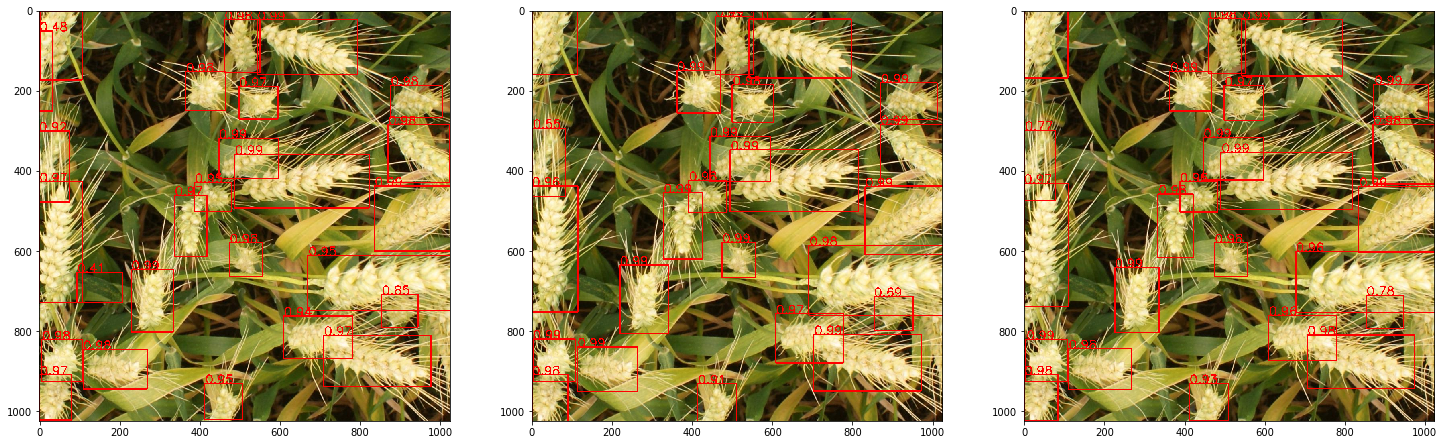

35
32
35


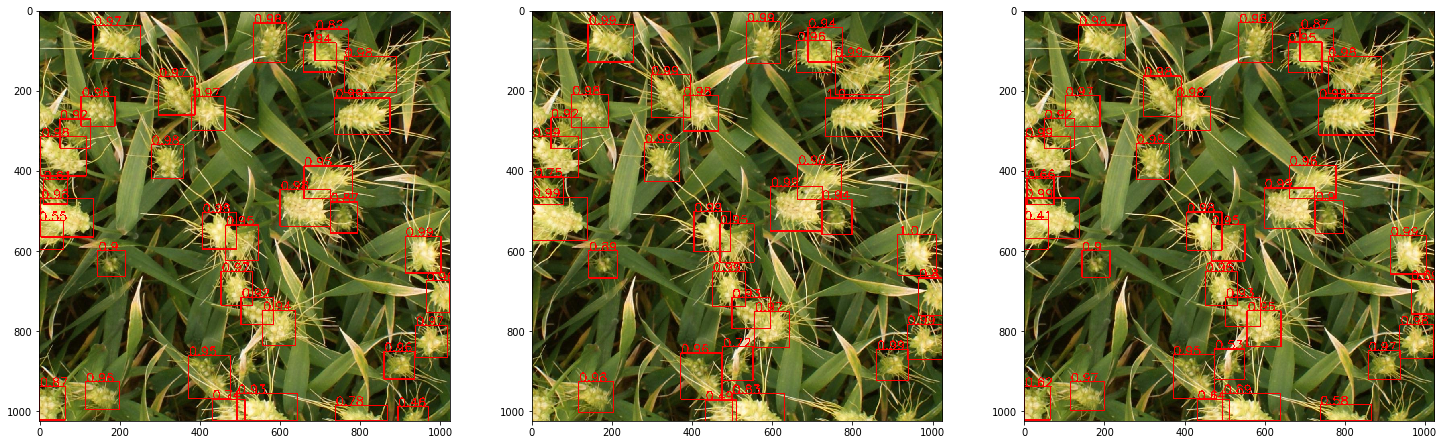

25
26
25


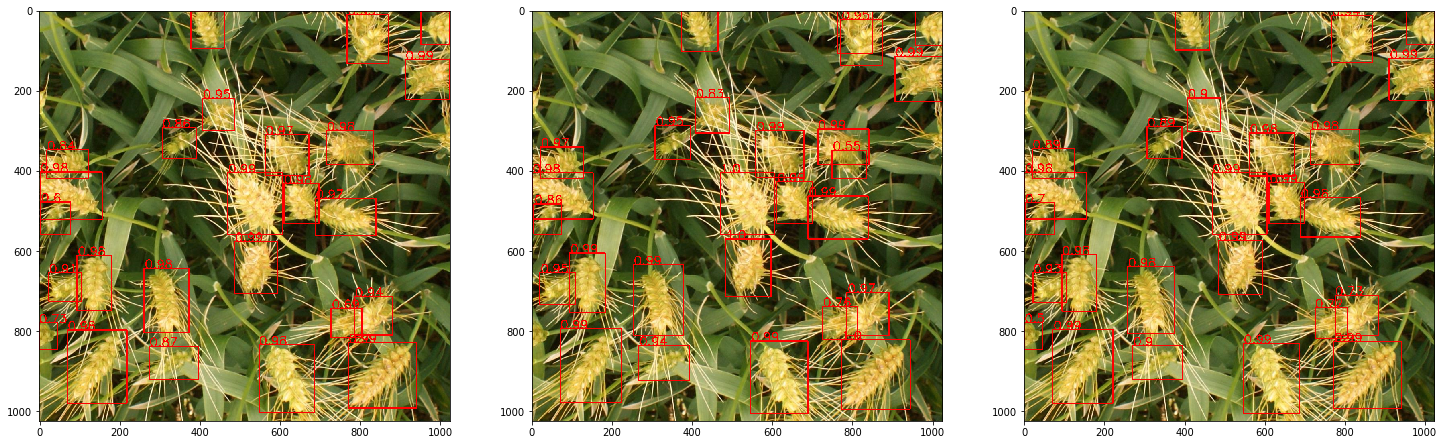

25
24
24


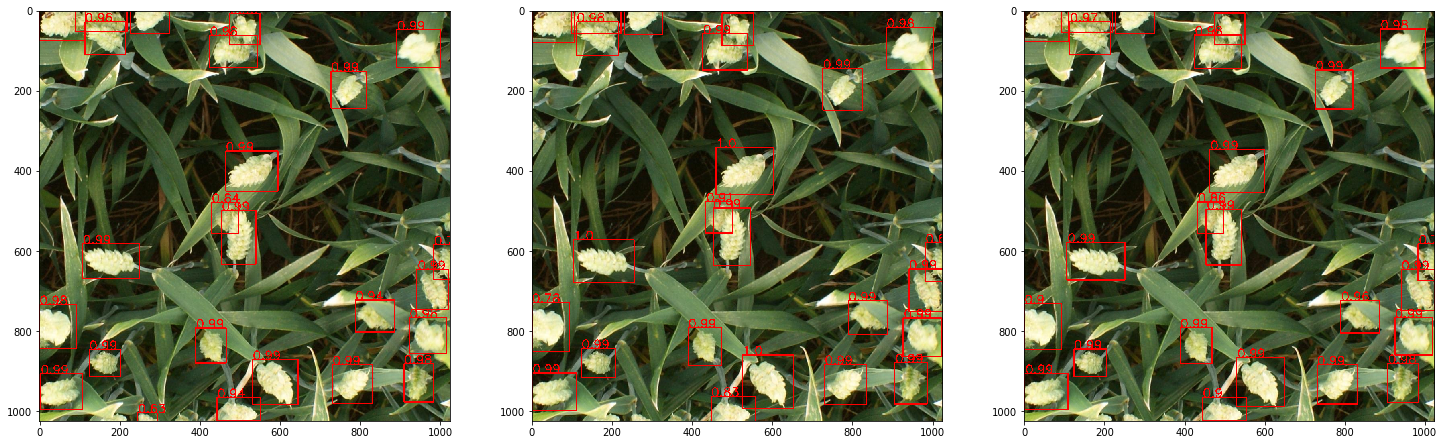

24
22
23


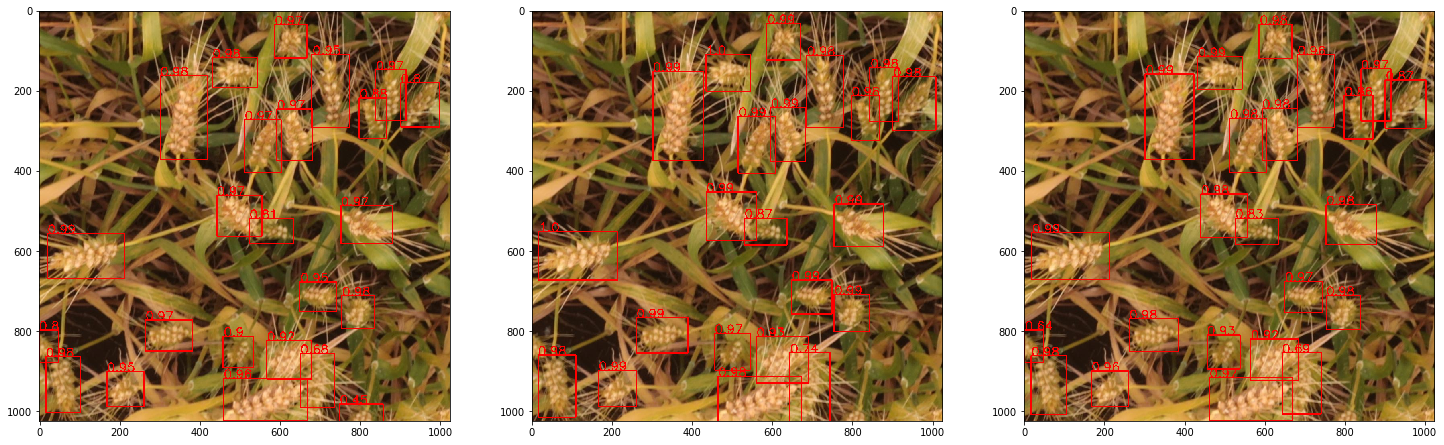

29
30
29


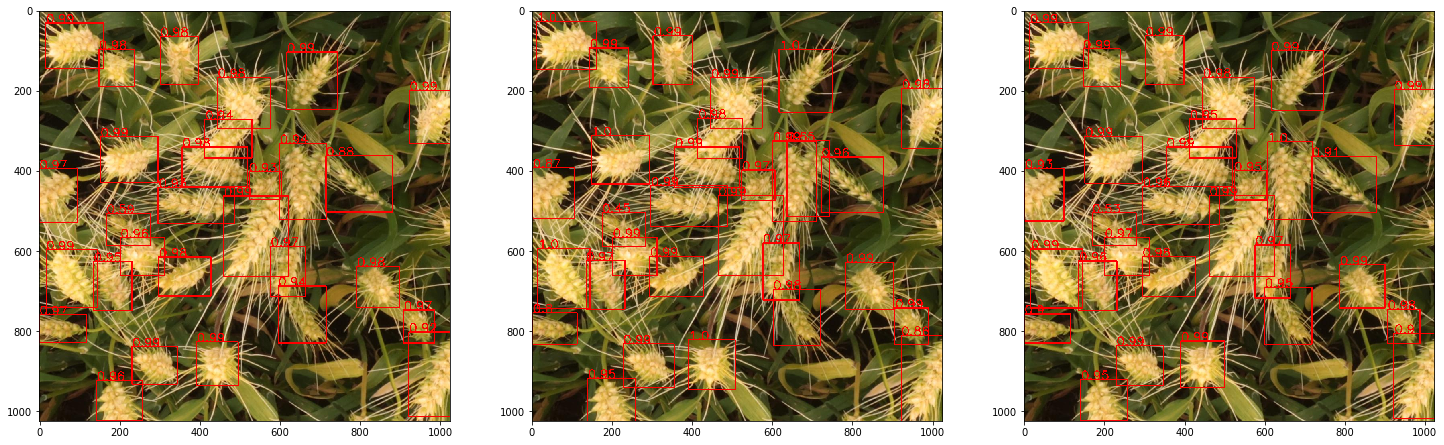

In [44]:
thresh=0.4

i=0
for img_id in WD_Inference.IMGS:
    
    fig = plt.figure(figsize=(25, 10))
    
    try:
        b__ = all_outputs[img_id][0]['boxes'][:np.argwhere(all_outputs[img_id][0]['scores']<thresh)[0][0]]
    except:
        b__ = all_outputs[img_id][0]['boxes']
        
    try:
        s__ = all_outputs[img_id][0]['scores'][:np.argwhere(all_outputs[img_id][0]['scores']<thresh)[0][0]]
    except:
        s__ = all_outputs[img_id][0]['scores']
    i__ = plot_boxes(images[i], b__, s__)
    fig.add_subplot(1, 3, 1)
    plt.imshow(i__)
    
    try:
        b__ = all_outputs[img_id][1]['boxes'][:np.argwhere(all_outputs[img_id][1]['scores']<thresh)[0][0]]
    except:
        b__ = all_outputs[img_id][1]['boxes']
        
    try:
        s__ = all_outputs[img_id][1]['scores'][:np.argwhere(all_outputs[img_id][1]['scores']<thresh)[0][0]]
    except:
        s__ = all_outputs[img_id][1]['scores']
    i__ = plot_boxes(images[i], b__, s__)
    fig.add_subplot(1, 3, 2)
    plt.imshow(i__)
    
    try:
        b__ = np.array(fused_outputs[img_id][0]['boxes'], dtype=np.float32)[:np.argwhere(fused_outputs[img_id][0]['scores']<thresh)[0][0]]
    except:
        b__ = np.array(fused_outputs[img_id][0]['boxes'], dtype=np.float32)
    try:
        s__ = np.array(fused_outputs[img_id][0]['scores'], dtype=np.float32)[:np.argwhere(fused_outputs[img_id][0]['scores']<thresh)[0][0]]
    except:
        s__ = np.array(fused_outputs[img_id][0]['scores'], dtype=np.float32)
    i__ = plot_boxes(images[i], b__, s__)
    fig.add_subplot(1, 3, 3)
    plt.imshow(i__)
    
    plt.show()
    i+=1

# Make Output

In [46]:
from fasterrcnn.utils.inferencefns import (format_prediction_string, 
                                           make_submission_file)

cut_off_thresh = 0.3
pred_strings = []
for image_id in WD_Inference.IMGS:
    scores = fused_outputs[img_id][0]['scores']
    try:
        stop_index = np.argwhere(scores<cut_off_thresh)[0][0]
    except:
        stop_index=len(result['scores'])

    pred_string = format_prediction_string(fused_outputs[img_id][0]['boxes'][:stop_index], scores[:stop_index])
    pred_strings.append(pred_string)


make_submission_file(WD_Inference.IMGS, pred_strings)

file_saved
